# Part 1: Data acquisition + cleanup
Adam Miles, CS6017
July 30 2017

# imports and setup 
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import os
import datetime
sns.set(style="dark")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model

filepath='/Users/adam/Box Sync/fonts/'
os.chdir(filepath)
df = pd.read_csv(f'HANDPRINT.csv')
#print(df.columns.values)

def transform(dataframe):
    #print(dataframe.columns.values)
    y = dataframe.loc[:,'m_label']
    cols = ['font','fontVariant','m_label','strength','italic','orientation','m_top','m_left','originalH','originalW','h','w']
    dataframe.drop(dataframe[cols], axis=1, inplace=True)
    X = np.reshape(dataframe.as_matrix(), (-1, 20, 20, 1))
    X = np.divide(X, 255)
    return X, y

In [2]:
Xs, ys = transform(df)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


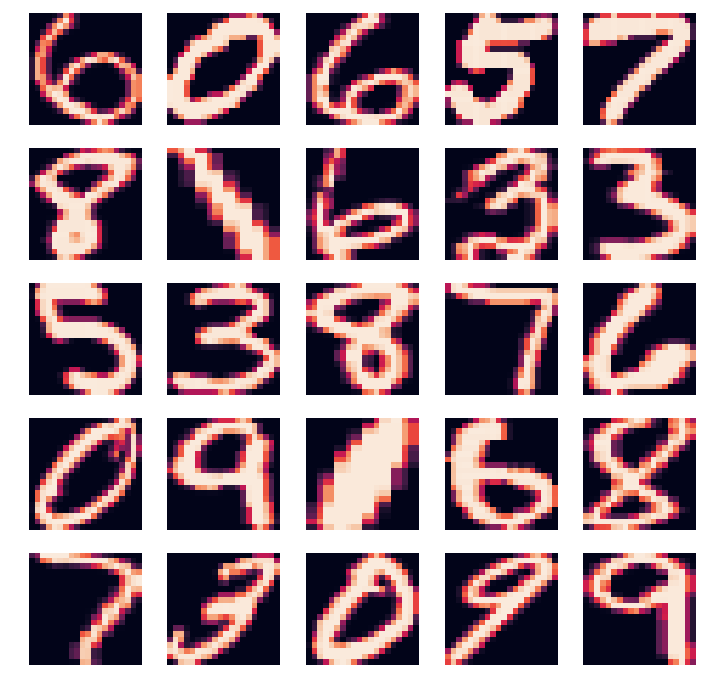

In [3]:
plt.figure(figsize= (12, 12))    
for ii in np.arange(25):
    plt.subplot(5, 5, ii+1)
    plt.imshow(np.reshape(Xs[ii,:],(20,20)), interpolation='nearest')
    plt.axis('off')
plt.show()

##### This data set appears to be only hand written digits (0-9) so it is of limited class size and is also very large (over 50000 series for training, roughly 5,000 per digit). It will make a good positive control, since our CNN's should perform very well. It does seem very similar to the MNIST training set.

# Step 3: Preparing data for a neural net


In [10]:
def one_hot_gen(ys):
    data = list(set(ys))
    char_to_ix = { ch:i for i,ch in enumerate(data) }
    ix_to_char = { i:ch for i,ch in enumerate(data) }
    
    integer_encoded = [char_to_ix[unicode] for unicode in ys]
    
    onehot_encoded = list()
    
    for value in integer_encoded:
        letter = [0 for _ in range(len(data))]
        letter[value] = 1
        onehot_encoded.append(letter)
    
    return np.asarray(onehot_encoded), char_to_ix, ix_to_char

In [11]:
ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

# Part 3: Build a keras network
### Naive CNN

In [12]:
batch_size = 32
num_classes = len (set(ys))
epochs = 12
input_shape = (20, 20, 1)

x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.8, random_state=1)

In [13]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
# invert encoding
inverted = ix_to_char[argmax(ys_hot[0])]
print(inverted)
num_classes

x_train shape: (14000, 20, 20, 1)
14000 train samples
56000 test samples
x_test shape: (56000, 20, 20, 1)
y_train shape: (14000, 10)
y_test shape: (56000, 10)
54


10

Train on 14000 samples, validate on 56000 samples
Epoch 1/12
14000/14000 [==============================] - 30s 2ms/step - loss: 0.4665 - acc: 0.8511 - val_loss: 0.1226 - val_acc: 0.9640
Epoch 2/12
14000/14000 [==============================] - 28s 2ms/step - loss: 0.1674 - acc: 0.9494 - val_loss: 0.0990 - val_acc: 0.9706
Epoch 3/12
14000/14000 [==============================] - 29s 2ms/step - loss: 0.1191 - acc: 0.9643 - val_loss: 0.0807 - val_acc: 0.9761
Epoch 4/12
14000/14000 [==============================] - 30s 2ms/step - loss: 0.0995 - acc: 0.9700 - val_loss: 0.0714 - val_acc: 0.9790
Epoch 5/12
14000/14000 [==============================] - 32s 2ms/step - loss: 0.0852 - acc: 0.9728 - val_loss: 0.0699 - val_acc: 0.9795
Epoch 6/12
14000/14000 [==============================] - 34s 2ms/step - loss: 0.0698 - acc: 0.9770 - val_loss: 0.0666 - val_acc: 0.9812
Epoch 7/12
14000/14000 [==============================] - 30s 2ms/step - loss: 0.0627 - acc: 0.9799 - val_loss: 0.0618 - val_acc

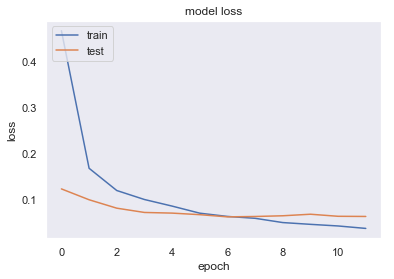

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), use_bias=True, activation='relu', data_format="channels_last", kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_last"))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[PlotLossesKeras()])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
score
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transfer-Learning Pattern (Attempt with Positive Control)

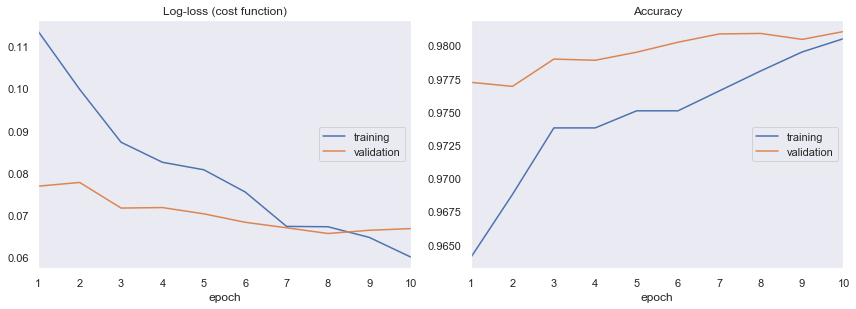

Training time: 0:02:45.779402
Test score: 0.0668120571047683
Test accuracy: 0.9810357142857142
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


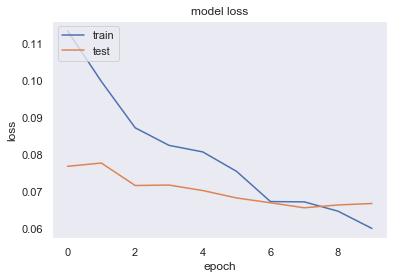

In [17]:
import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from livelossplot import PlotLossesKeras

now = datetime.datetime.now

batch_size = 128
num_classes = len (set(ys))
init_epochs = 5
transfer_epochs = 10

img_rows, img_cols = 20, 20
filters = 32
pool_size = 2
kernel_size = 3

input_shape = (img_rows, img_cols, 1)

def train_model(model, x, y, num_classes, epochs):
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    t = now()
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=[PlotLossesKeras()])
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

split = int(len (set(ys))/10)
x_train_lower = x_train[:split]
y_train_lower = y_train[:split]
x_test_lower = x_test[:split]
y_test_lower = y_test[:split]

x_train_upper = x_train[split:]
y_train_upper = y_train[split:] - split
x_test_upper = x_test[split:]
y_test_upper = y_test[split:] - split


feature_layers = [
    Conv2D(filters, kernel_size, padding='valid', input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

# create complete model
model = Sequential(feature_layers + classification_layers)


train_model(model,
            (x_train_lower, y_train_lower),
            (x_test_lower, y_test_lower), num_classes, init_epochs)

# freeze feature layers and rebuild model
for l in feature_layers:
    l.trainable = False

# transfer: train dense layers for new classification task [100- ~3600]
train_model(model,
            (x_train_upper, y_train_upper),
            (x_test_upper, y_test_upper), num_classes, transfer_epochs)

score = model.evaluate(x_test, y_test, verbose=0)

# Part 4: Exploration and Evaluation

### Fully refactored and cleaned up the methods explored above for easier use.

In [72]:
# imports and setup 
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(flatui))
import os
import datetime
sns.set(style="dark")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import datetime
# found these through lots of web searching, helpful for exploring the performance of each model.
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report

from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

fonts = ['AGENCY', 'BRADLEY','CAMBRIA','COURIER', 'COMIC', 'HANDPRINT','HARLOW','HARRINGTON','IMPACT','IMPRINT',
'ITALIC', 'JUICE','LEELAWADEE','LUCIDA','MAGNETO','MISTRAL','MODERN','RAGE','ROMAN']
#fonts = ['AGENCY', 'BRADLEY','CAMBRIA','COURIER']
col_names =  ['Font', 'Score', 'Accuracy']
results  = []

def get_data(font_name):
    filepath='/Users/adam/Box Sync/fonts/'
    os.chdir(filepath)
    df = pd.read_csv(font_name + '.csv')
    return df

def get_latin_only(font_name):
    filepath='/Users/adam/Box Sync/fonts/'
    os.chdir(filepath)
    latin_range = list(range(32, 256))
    df = pd.read_csv(font_name + '.csv')
    #df_worst = df[df['m_label'].isin(worst_chars)].iloc[:20, :]
    latin_only = df[df['m_label'].isin(latin_range)]
    
    return latin_only

def transform(dataframe):
    #print(dataframe.columns.values)
    y = dataframe.loc[:,'m_label']
    cols = ['font','fontVariant','m_label','strength','italic','orientation','m_top','m_left','originalH','originalW','h','w']
    dataframe.drop(dataframe[cols], axis=1, inplace=True)
    X = np.reshape(dataframe.as_matrix(), (-1, 20, 20, 1))
    X = np.divide(X, 255)
    return X, y

def transform(dataframe):
    #print(dataframe.columns.values)
    y = dataframe.loc[:,'m_label']
    cols = ['font','fontVariant','m_label','strength','italic','orientation','m_top','m_left','originalH','originalW','h','w']
    dataframe.drop(dataframe[cols], axis=1, inplace=True)
    X = np.reshape(dataframe.as_matrix(), (-1, 20, 20, 1))
    X = np.divide(X, 255)
    return X, y

def one_hot_gen(ys):
    now = datetime.datetime.now
    data = list(set(ys))
    char_to_ix = { ch:i for i,ch in enumerate(data) }
    ix_to_char = { i:ch for i,ch in enumerate(data) }
    
    integer_encoded = [char_to_ix[unicode] for unicode in ys]
    
    onehot_encoded = list()
    
    for value in integer_encoded:
        letter = [0 for _ in range(len(data))]
        letter[value] = 1
        onehot_encoded.append(letter)
    
    return np.asarray(onehot_encoded), char_to_ix, ix_to_char

def train_model(model, x_train, y_train, x_test, y_test, num_classes, epochs, batch_size):
    now = datetime.datetime.now
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=[PlotLossesKeras()])
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    
def train_TL_CNN(results):

    batch_size = 128
    init_epochs = 5
    transfer_epochs = 10
    img_rows, img_cols = 20, 20
    filters = 32
    pool_size = 2
    kernel_size = 3
    
    input_shape = (img_rows, img_cols, 1)
    
    for font in fonts:
        print('Training font: %s' % font)
        df = get_data(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)
        
        num_classes = len(set(ys))
        print(num_classes)
        
        x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.8, random_state=1)
        x_t1, x_t2, y_t1, y_t2 = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

        # define two groups of layers: feature (convolutions) and classification (dense)
        feature_layers = [
            Conv2D(filters, kernel_size, padding='valid', input_shape=input_shape),
            Activation('relu'),
            Conv2D(filters, kernel_size),
            Activation('relu'),
            MaxPooling2D(pool_size=pool_size),
            Dropout(0.25),
            Flatten(),
        ]

        classification_layers = [
            Dense(128),
            Activation('relu'),
            Dropout(0.5),
            Dense(num_classes),
            Activation('softmax')
        ]

        # create complete model
        model = Sequential(feature_layers + classification_layers)

        # train model for 100-digit classification [0..split]
        train_model(model, x_t1, y_t1, x_t2, y_t2, num_classes, init_epochs, batch_size)

        # freeze feature layers and rebuild model
        for l in feature_layers:
            l.trainable = False

        # transfer: train dense layers for new classification task
        train_model(model, x_train, y_train, x_test, y_test, num_classes, transfer_epochs, batch_size)  
        score = model.evaluate(x_test, y_test, verbose=0)
        
        results.append({
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'Model' : 'Transfer-Learning'
        })

def train_Basic_CNN(results, _epochs, test_fonts):
    batch_size = 128
    epochs = _epochs
    img_rows, img_cols = 20, 20
    filters = 32
    pool_size = 2
    kernel_size = 3
    
    input_shape = (img_rows, img_cols, 1)
    
    for font in test_fonts:
        df = get_data(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        num_classes = len(set(ys))
        print(num_classes)

        x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.8, random_state=1)
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), use_bias=True, activation='relu', data_format="channels_last", kernel_initializer='glorot_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_last"))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test),
                  callbacks=[PlotLossesKeras()])
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        
        results.append({
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'Model' : 'Basic',
            'state' : model
        })
    return model

def train_Experimental_CNN(results, _epochs, test_fonts):
    batch_size = 128
    epochs = _epochs
    img_rows, img_cols = 20, 20
    filters = 32
    pool_size = 2
    kernel_size = 3
    
    input_shape = (img_rows, img_cols, 1)
    
    for font in test_fonts:
        df = get_data(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        num_classes = len(set(ys))
        print(num_classes)

        x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.8, random_state=1)
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(5, 5),
                         activation='relu',
                         input_shape=input_shape))
        model.add(Conv2D(128, (6, 6), use_bias=True, activation='relu', data_format="channels_last", kernel_initializer='glorot_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_last"))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test),
                  callbacks=[PlotLossesKeras()])
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        
        results.append({
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'Model' : 'Basic',
            'state' : model
        })
def top_10_misclassified(font_reports):
    # plot the worst categoires
    for report in font_reports:
        df = get_data(report.get('Font'))
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        y_test = np.argmax(ys_hot, axis=1) # Convert one-hot to index
        y_pred = report.get('state').predict_classes(Xs)
        
        report = classification_report(y_test, y_pred)
        print(report.get('Font'))
        plt.figure(figsize= (12, 12))    
        for ii in np.arange(10):
            print('font')
            plt.subplot(5, 2, ii+1)
            plt.imshow(np.reshape(Xs[ii,:],(20,20)), interpolation='nearest')
            plt.axis('off')
        plt.show()

def train_latin_CNN(results, _epochs, test_fonts):
    batch_size = 128
    epochs = _epochs
    img_rows, img_cols = 20, 20
    filters = 32
    pool_size = 2
    kernel_size = 3
    
    input_shape = (img_rows, img_cols, 1)
    
    for font in test_fonts:
        df = get_latin_only(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        num_classes = len(set(ys))
        print(font)

        x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.2, random_state=1)
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), use_bias=True, activation='relu', data_format="channels_last", kernel_initializer='glorot_uniform'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_last"))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])

        history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test))
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        
        results.append({
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'Model' : 'Basic',
            'state' : model
        })
    return model
        
def character_distribution(list_of_fonts, counts):
    for font in list_of_fonts:
        df = get_data(font)
        counts.update(df['m_label'].value_counts().to_dict())

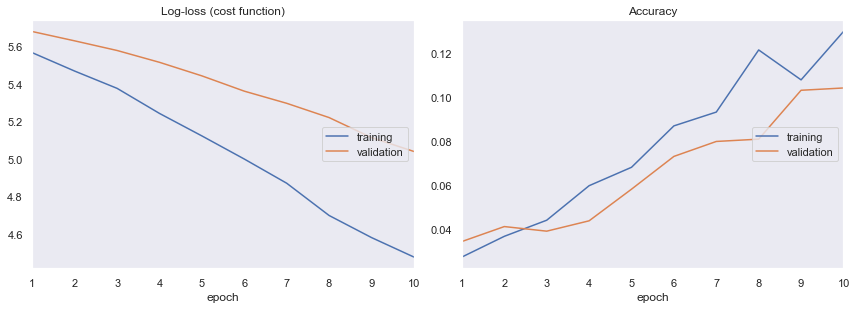

Training time: 0:00:21.101855
Test score: 5.039298710227793
Test accuracy: 0.10416121435154486


In [11]:
train_TL_CNN(results)
df = pd.DataFrame.from_dict(results)

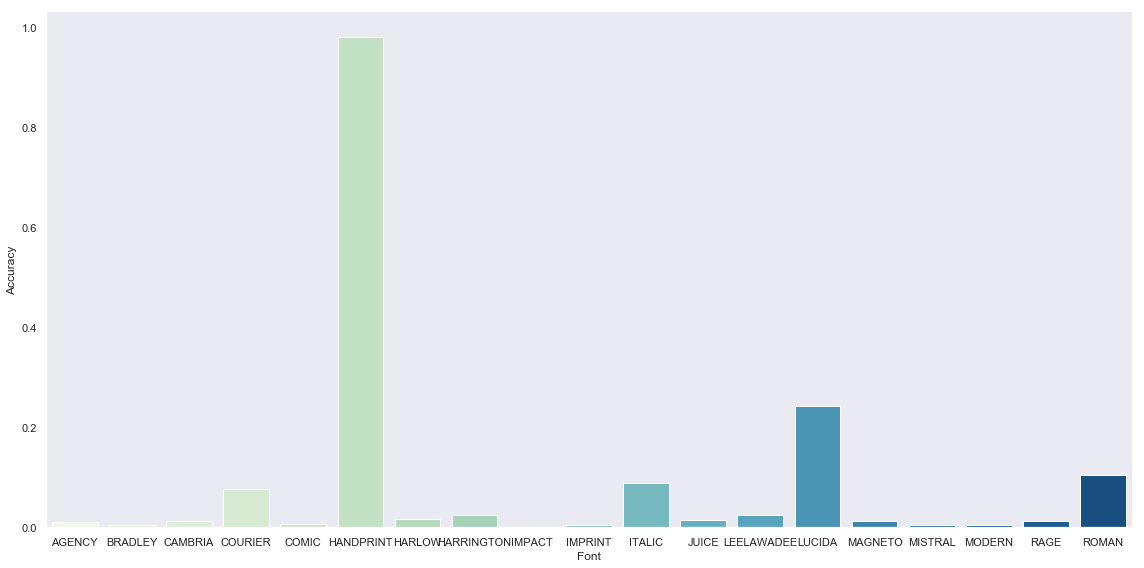

In [12]:
g = sns.catplot(x="Font", y="Accuracy", data=df, kind="bar", palette="GnBu",height=8, aspect=2)        

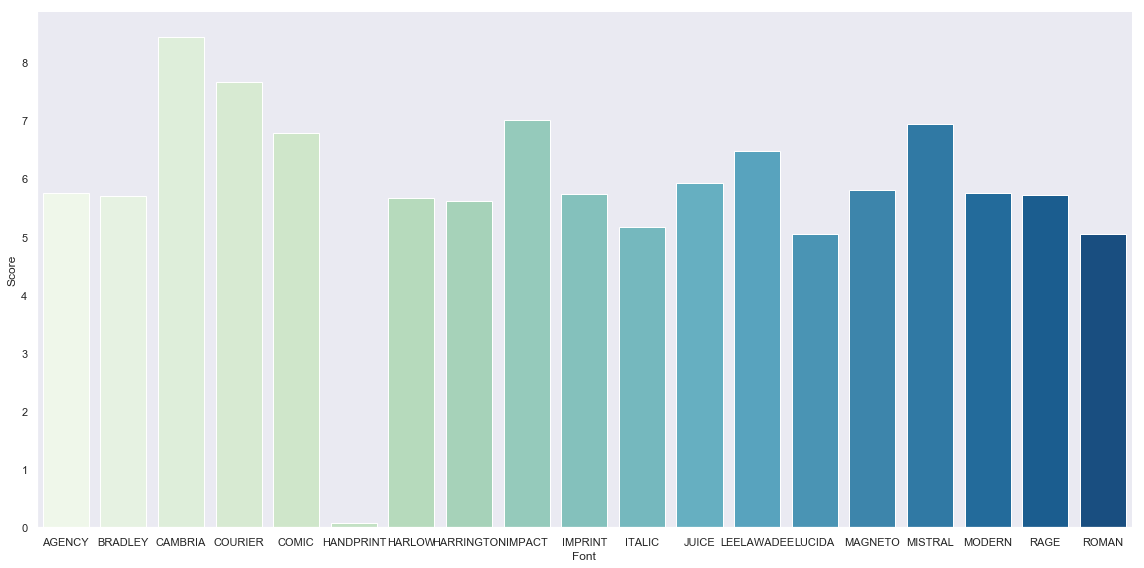

In [13]:
g = sns.catplot(x="Font", y="Score", data=df, kind="bar", palette="GnBu",height=8, aspect=2) 

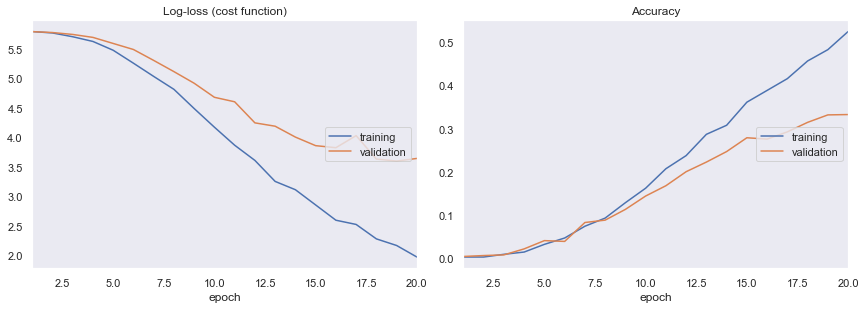

Test loss: 3.6395307915025406
Test accuracy: 0.3326354357888018


In [14]:
train_Basic_CNN(results, 20, fonts)

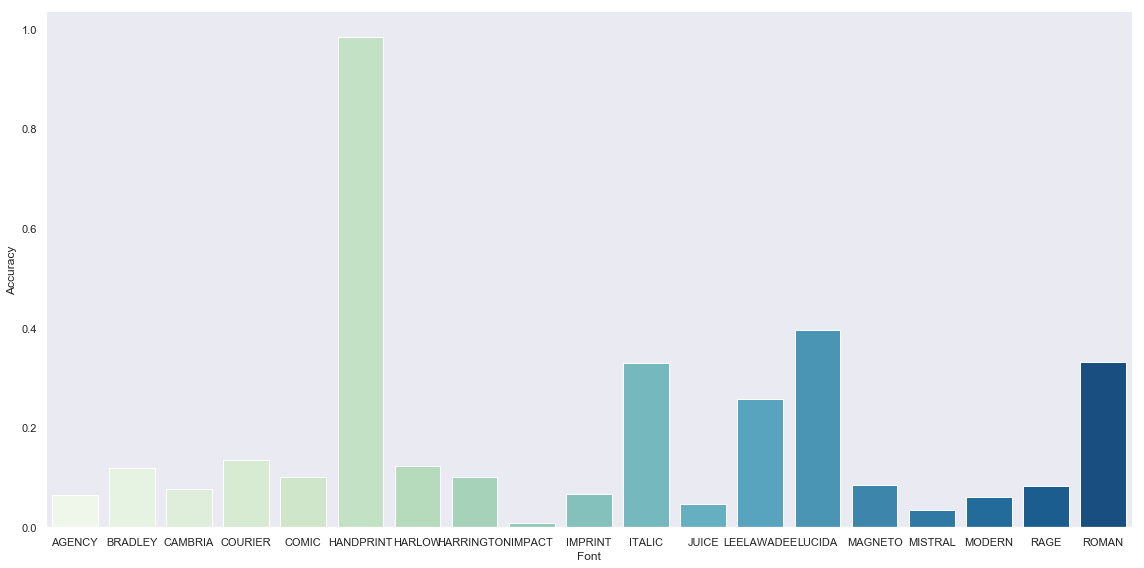

In [15]:
df = pd.DataFrame.from_dict(results)
basic = df['Model'] == 'Basic'
g = sns.catplot(x="Font", y="Accuracy", data=df[basic], kind="bar", palette="GnBu",height=8, aspect=2) 

In [16]:
df.to_csv('ALL_FONTS.csv')

In [39]:
counts = {}

for font in fonts:
    df = get_data(font)
    counts.update({ font : df['m_label'].value_counts().to_dict()})

We can see that the distributions are pretty uniform for each fontset, with at least 4 examples of every character (though the range included varies).

While monitoring the log-loss during fitting, there were a number of fonts that could benefit from more epochs. Additionally, we know that the HANDPRINT font is essentially our positive control, and that we will need to change things from here if we want to improve the models for some of the more promising fonts.

All fonts with an accuracy above 20% were selected for this next round, and the BASIC model was kept with a few modifications.

In [17]:
font_subset = []
for record in results:
    if (record.get('Accuracy') > 0.2):
        font_subset.append(record.get('Font'))
font_subset.remove('HANDPRINT')

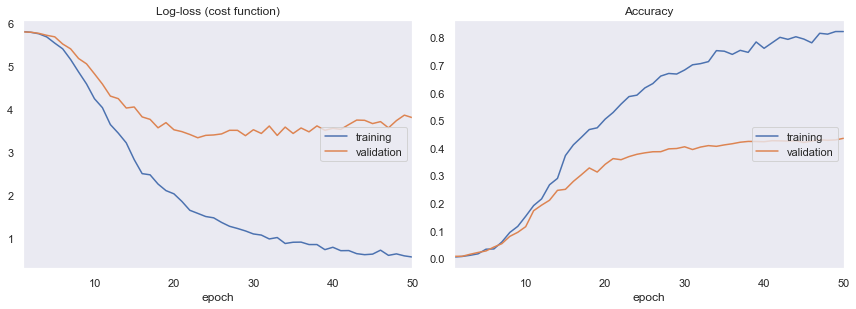

Test loss: 3.796767451319511
Test accuracy: 0.4341795341611626


In [18]:
subset_results = []
train_Basic_CNN(subset_results, 50, font_subset)

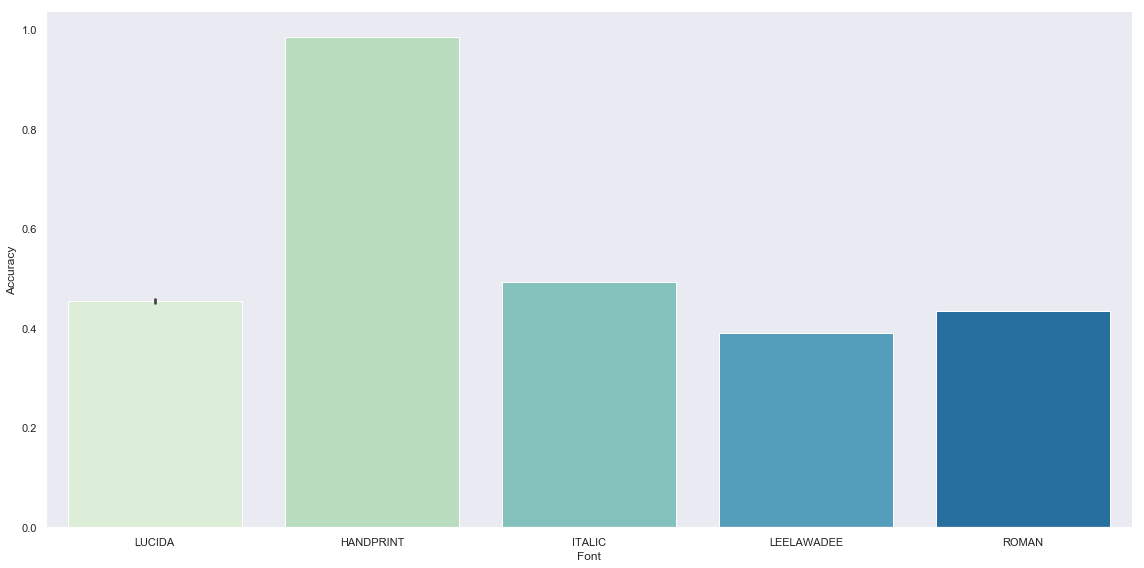

In [33]:
df = pd.DataFrame.from_dict(subset_results)
g = sns.catplot(x="Font", y="Accuracy", data=df, kind="bar", palette="GnBu",height=8, aspect=2) 

In [34]:
df.to_csv('SUBSET_FONTS.csv')

In [36]:
#retrain subset with (8,8) Conv2D and extra dense layer with additional dropout.
print(font_subset)

['ITALIC', 'LUCIDA', 'ROMAN']


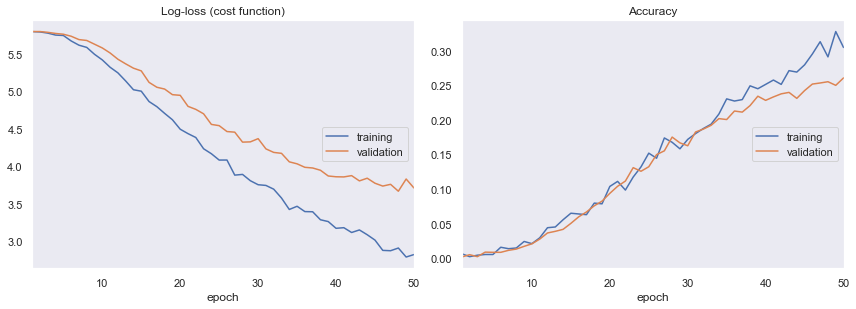

Test loss: 3.708326778621519
Test accuracy: 0.26066474748731


In [37]:
opt_subset_results = []
train_Experimental_CNN(opt_subset_results, 50, font_subset)

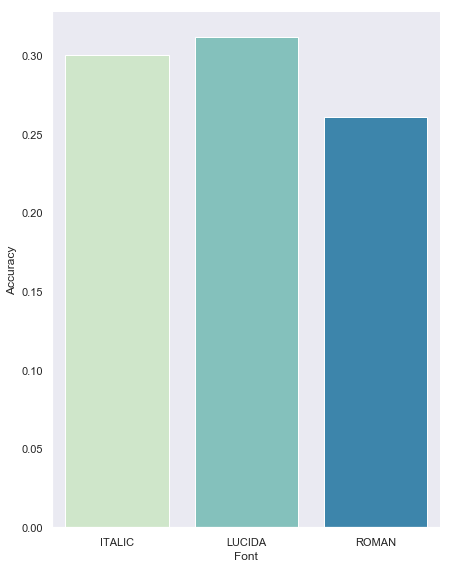

In [43]:
df = pd.DataFrame.from_dict(opt_subset_results)
g = sns.catplot(x="Font", y="Accuracy", data=df, kind="bar", palette="GnBu",height=8, aspect=0.8)

It looks like the 3rd modification set performed even worse, and it took much longer as well.

In [39]:
df.to_csv('OPT_SUBSET_FONTS.csv')

In [41]:
opt_subset_results

[{'Font': 'ITALIC',
  'Score': 3.651683795171153,
  'Accuracy': 0.30000000012041345,
  'Model': 'Basic',
  'state': <keras.engine.sequential.Sequential at 0x17dbe3ba8>},
 {'Font': 'LUCIDA',
  'Score': 4.642429134623168,
  'Accuracy': 0.3116915217953203,
  'Model': 'Basic',
  'state': <keras.engine.sequential.Sequential at 0x12960f080>},
 {'Font': 'ROMAN',
  'Score': 3.708326778621519,
  'Accuracy': 0.26066474748731,
  'Model': 'Basic',
  'state': <keras.engine.sequential.Sequential at 0x194d16828>}]

In [73]:
def top_20_misclassified(opt_subset_results):
    # plot the worst categoires
    for report in opt_subset_results:
        print(report.get('Font'))
        df = get_data(report.get('Font'))
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        y_test = np.argmax(ys_hot, axis=1) # Convert one-hot to index
        y_pred = report.get('state').predict_classes(Xs)
        
        # generate and format the report
        class_report = classification_report(y_test, y_pred)
        report_data = []
        lines = class_report.split('\n')
        for line in lines[2:-3]:
            row = {}
            row_data = line.split('      ')
            """
            this stupid first row in the output format cannot be converted to an int!!!!!
            what is wrong with this stupid report format!!!!!
            i can convert to string (supposedly) but it still complains about an invalid conversion
            to int when i use the column below, but it always shows up as an object.
            """
            # row['class'] = int(row_data[0])
            row['class'] = str(row_data[0])
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
            
        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv('report_results.csv')
        dataframe = pd.read_csv('report_results.csv')

        worst = dataframe.sort_values(by=['f1_score']).iloc[:20, 0]
        worst_chars = worst.values.tolist()
        df = get_data(report.get('Font'))
        df_worst = df[df['m_label'].isin(worst_chars)].iloc[:20, :]
        Xf, yf = transform(df_worst)
        plt.figure(figsize=(12, 12)) 
        for ii in np.arange(20):
            plt.subplot(4, 5, ii+1)
            plt.imshow(np.reshape(Xf[ii,:],(20,20)), interpolation='nearest')
            plt.axis('off')
        plt.show()

ITALIC


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


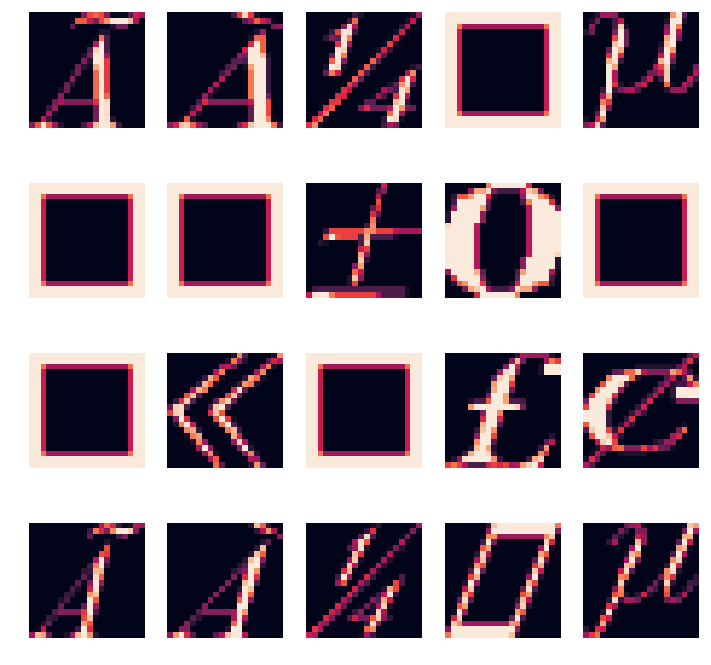

LUCIDA


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


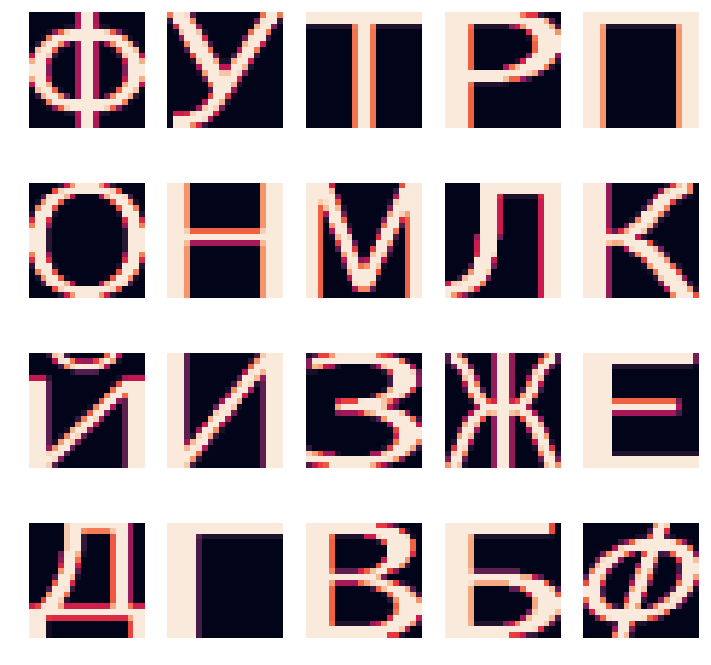

ROMAN


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


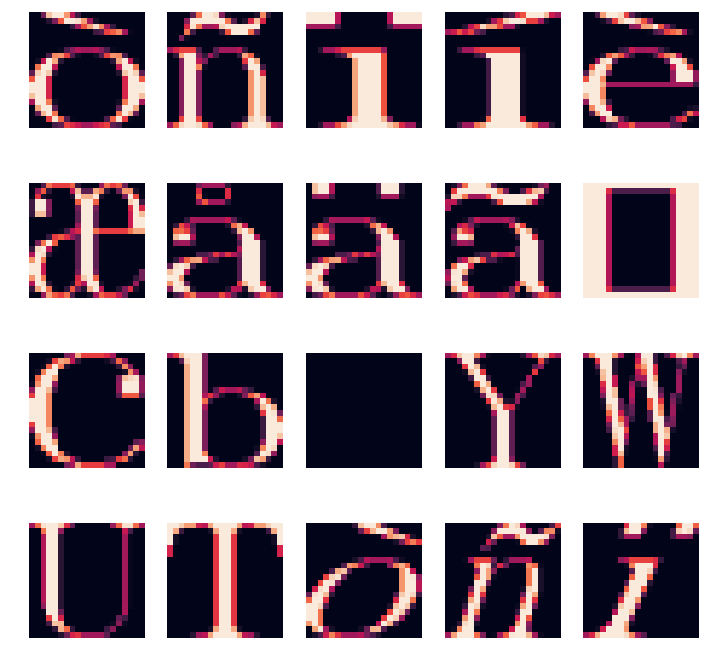

In [259]:
# have a look at the worst characters in each set, and see if there are any reasonable patterns
top_20_misclassified(opt_subset_results)

We can see that the models had a really hard time with the many variations of the vowels with diacritics. Oddly Lucida seemed to really struggle with greek characters, likely confusing them with the standard roman notation. There are also some box-like characters that it cannot differentiate. I assume these have some special purpose and meaning, but for humans or these models they are indistinguishable.

Testing with a different font's models yields very poor results. This method executes a combinatorial testing matrix, in which each font is tested with every other fonts models in the set. To do so, the larger data set has to be filtered down to just the characters in the smaller set, such that the number of classes in the output layer match appropriately. I was unable to execute a reasonable way to do this, even for just the first 200 unicode chars.

For this last set of experiments, I focused on only the latin characters (basically the ascii range of unicode) to make the comparison between fonts a little easier.

In [74]:
ascii_results = []

fonts = ['AGENCY','CAMBRIA','COURIER', 'COMIC','IMPACT','IMPRINT',
'JUICE','LEELAWADEE','LUCIDA','MAGNETO','MISTRAL','MODERN','RAGE']


In [ ]:
#fonts = ['AGENCY','CAMBRIA','COMIC','RAGE']
train_latin_CNN(ascii_results, 100, fonts)
df = pd.DataFrame.from_dict(results)

In [76]:
cross_results = []
def perf_matrix(cross_results, _epochs, test_fonts, subset_results):
    
    batch_size = 128
    epochs = _epochs
    img_rows, img_cols = 20, 20
    filters = 32
    pool_size = 2
    kernel_size = 3

    input_shape = (img_rows, img_cols, 1)

    for font_model in subset_results:
        model = font_model.get('state')
        print('Testing font model: ' + font_model.get('Font'))

        df_model = get_latin_only(font_model.get('Font'))
        for font in test_fonts:
            #print('Testing: ' + font)
            df_font = get_latin_only(font)
            df_font = df_font[df_font['m_label'].isin(list(df_model['m_label']))]

            #print(df_font.shape)
            #print(df_model.shape)

            Xs, ys = transform(df_font)
            ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

            num_classes = len(set(ys))
            #print(num_classes)

            x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.8, random_state=1)

            score = model.evaluate(x_test, y_test, verbose=0)
            """
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
            """

            cross_results.append({
                'Font' : font, 
                'Accuracy' : score[1],
                'Model' : font_model.get('Font'),
            })

In [77]:
perf_matrix(cross_results, 50, fonts, ascii_results)

Testing font model: AGENCY


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Testing font model: CAMBRIA
Testing font model: COURIER
Testing font model: COMIC
Testing font model: IMPACT
Testing font model: IMPRINT
Testing font model: JUICE
Testing font model: LEELAWADEE
Testing font model: LUCIDA
Testing font model: MAGNETO
Testing font model: MISTRAL
Testing font model: MODERN
Testing font model: RAGE


In [78]:
cx = pd.DataFrame.from_dict(cross_results)
cx.to_csv('cx.csv')

In [84]:
cx = pd.read_csv('cx.csv')

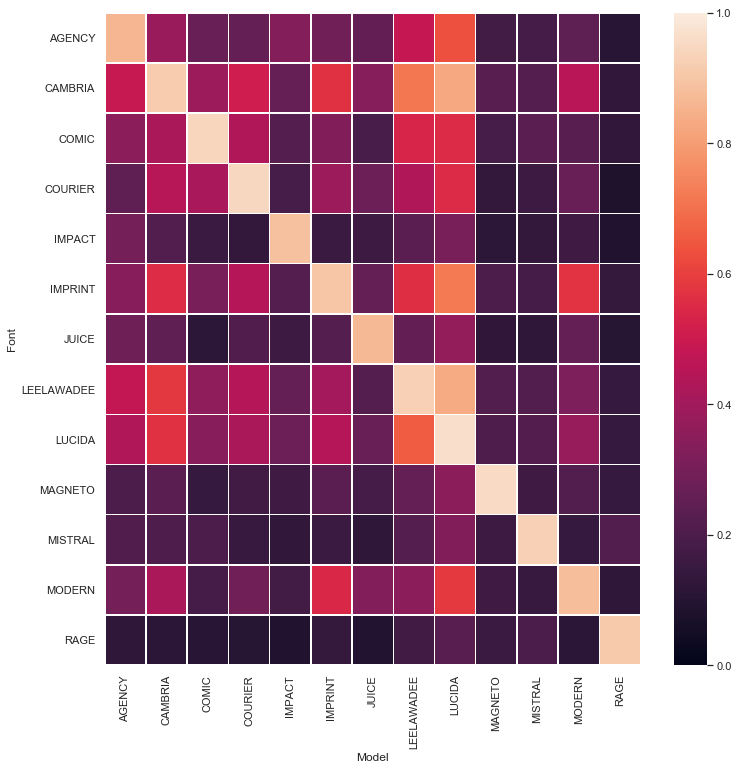

In [150]:
matrix = cx.pivot("Font", "Model", "Accuracy")
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, fmt="f", linewidths=.5, ax=ax, vmin=0, vmax=1)

From the heatmap we can see that Lucida performs remarkably well across the board, and in some cases is able to more accurately predict characters from other fonts than their own models. More highly stylized fonts like 'Rage' and 'Magento' performed well for themselved but not for any other font. This could tell us something about the 'Lucida' font as well as 'Cambria' and 'Leelawadee', as having strong (or strongly correlated) latin font elements. I am not a font designer, but I believe they all hail from the same font family. Lucid was designed to reflect traditional roman letterforms while also optimizing for on screen legibility. It is a seriffed font, like courier and many of the others if performed very well with. It would probably serve well as an initial model for further training on the other font sets. To better reveal how well each font performs relative to one another, we can normalize for each models performance with its own font vs others.

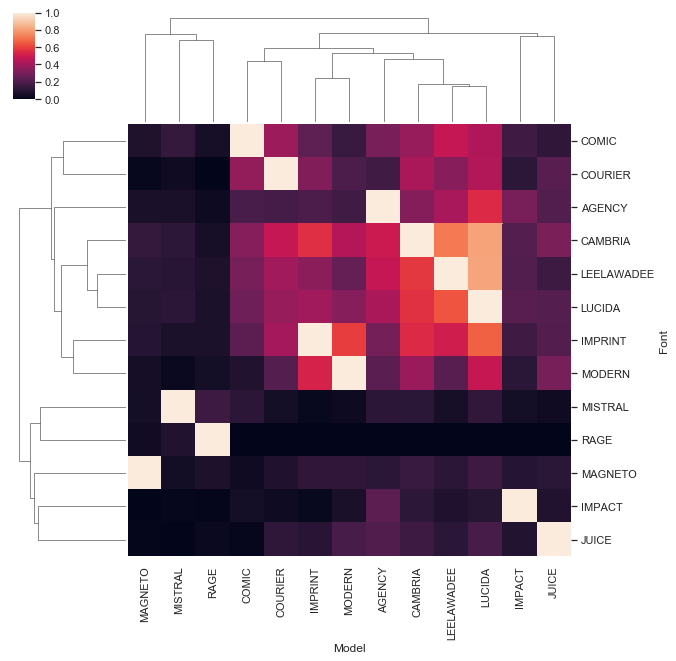

In [149]:
g = sns.clustermap(matrix, standard_scale=1)

If we look at the two major classes of fonts revealed in this matrix, they do break down more or less by font type. This lends us some interesting options for performing some informed training on multiple font data sets. It seems unlikely that one model will be able to describe all fonts (ascii chars only) but we can try that as a first pass. We could also try to train on just the clustered fonts. I am unsure if the order in which we train the models matters, but it seems like a good idea to start with the most general as our seed model, so we can see that 'Lucida' will best serve that purpose from this set. It will be interesting to see if its accuracy can remain at least as good (0.96) as it currently is while still accomodating newer fonts.

In [120]:
def chain_train(model, input_fonts, in_progress_results, trained_results):
    for font in input_fonts:
        batch_size = 128
        epochs = 50
        img_rows, img_cols = 20, 20
        filters = 32
        pool_size = 2
        kernel_size = 3

        input_shape = (img_rows, img_cols, 1)
        df = get_latin_only(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        num_classes = len(set(ys))
        print(num_classes)

        x_train, x_test, y_train, y_test = train_test_split(Xs, ys_hot, test_size=0.2, random_state=1)

        history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[PlotLossesKeras()])
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        in_progress_results.update({ font : {
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'state' : model
        }})
    
    for font in input_fonts:
        df = get_latin_only(font)
        Xs, ys = transform(df)
        ys_hot, char_to_ix, ix_to_char = one_hot_gen(ys)

        num_classes = len(set(ys))
        print(num_classes)

        score = model.evaluate(Xs, ys_hot, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        
        trained_results.update({ font : {
            'Font' : font, 
            'Score' : score[0], 
            'Accuracy' : score[1],
            'state' : model
        } })

In [155]:
crossed = {k: v for k, v in zip(fonts, ascii_results)}

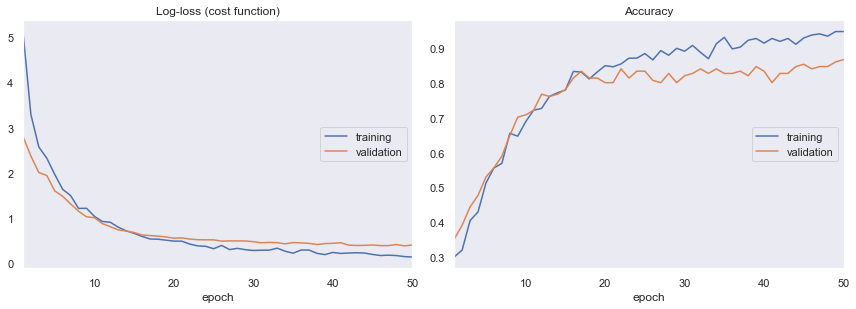

Test loss: 0.40639808695047897
Test accuracy: 0.8675496720320341
188
Test loss: 1.92225344637607
Test accuracy: 0.6289893617021277
188
Test loss: 0.5980361148397974
Test accuracy: 0.8497340425531915
188
Test loss: 1.7557691803658984
Test accuracy: 0.6723677178935403
188
Test loss: 1.2659082006900868
Test accuracy: 0.7367021276595744
188
Test loss: 3.200131634448437
Test accuracy: 0.44813829787234044
188
Test loss: 0.7057547946559622
Test accuracy: 0.8324468085106383
188
Test loss: 2.6108716396575278
Test accuracy: 0.5664893617021277
188
Test loss: 0.708805265222141
Test accuracy: 0.8218085106382979
188
Test loss: 0.511431124609978
Test accuracy: 0.8628628628628628
188
Test loss: 0.5638467035395034
Test accuracy: 0.8377659574468085
188
Test loss: 0.4111902206502062
Test accuracy: 0.8696808510638298
188
Test loss: 0.3903432979862741
Test accuracy: 0.8829787234042553
188
Test loss: 0.10854625430433675
Test accuracy: 0.961436170212766


In [156]:
chain_results = {}
prog_results = {}
chain_trained = crossed.get('LUCIDA').get('state')
chain_train(chain_trained, fonts, prog_results, chain_results)

In [157]:
xm = pd.DataFrame.from_dict(chain_results, orient='index')
xm.to_csv('xm.csv')
xm = pd.read_csv('xm.csv')

In [158]:
matrix = xm.pivot("Font", "Model", "Accuracy")

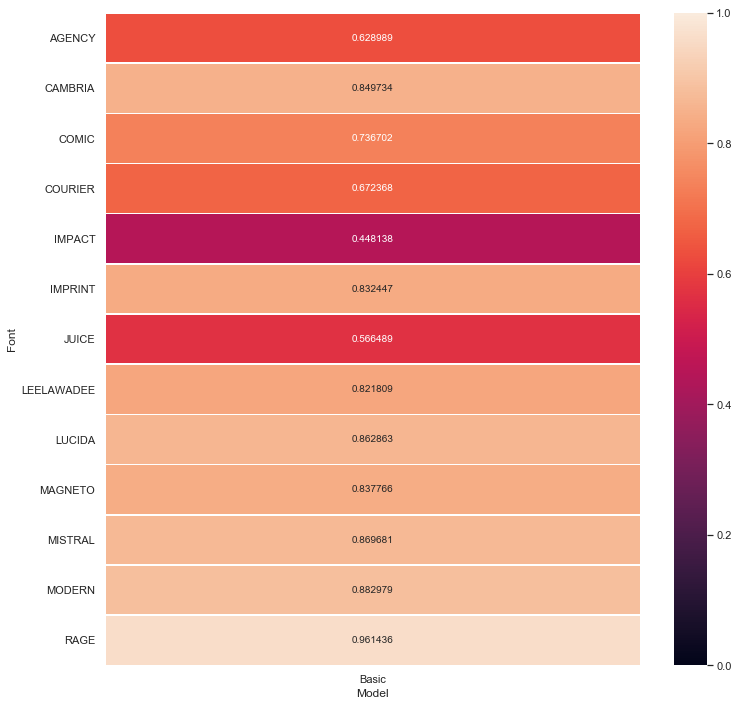

In [159]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix, annot=True, fmt="f", linewidths=.5, ax=ax, vmin=0, vmax=1)

Surprisingly, this very rudimentary approach helped us gain significant accuracy across the data set, even if it cost us about 9% accuracy on the original seed model for its training font (LUCIDA). We could try to run it again and see if it will improve, but i'm not exactly sure how that would be too different from merging all the fonts into one giant, randomized data set. At lest this way we can easily see which fonts the model is struggling with. We could also see all of the fonts in the collection with this model and see if it improves their portability, if that were a desireable feature. 

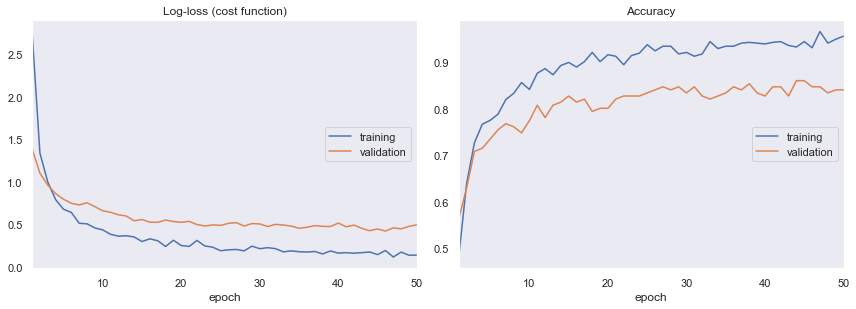

Test loss: 0.49286496362938786
Test accuracy: 0.8410596058068686
188
Test loss: 1.3741922074175896
Test accuracy: 0.7167553191489362
188
Test loss: 0.4585741031518642
Test accuracy: 0.898936170212766
188
Test loss: 1.1989377042719669
Test accuracy: 0.7546766436017177
188
Test loss: 1.0019670090776809
Test accuracy: 0.7726063829787234
188
Test loss: 2.4332279195176794
Test accuracy: 0.5811170212765957
188
Test loss: 0.49030612959982234
Test accuracy: 0.8936170212765957
188
Test loss: 2.127774914528461
Test accuracy: 0.6476063829787234
188
Test loss: 0.5789319071228284
Test accuracy: 0.8650265957446809
188
Test loss: 0.3870368185540176
Test accuracy: 0.9032365699032365
188
Test loss: 0.33487142844403045
Test accuracy: 0.9148936170212766
188
Test loss: 0.22585097494277548
Test accuracy: 0.9162234042553191
188
Test loss: 0.27912912216592345
Test accuracy: 0.9281914893617021
188
Test loss: 0.11978585534590355
Test accuracy: 0.9561170212765957


In [160]:
chain_results2 = {}
prog_results2 = {}
chain_train(chain_trained, fonts, prog_results, chain_results)

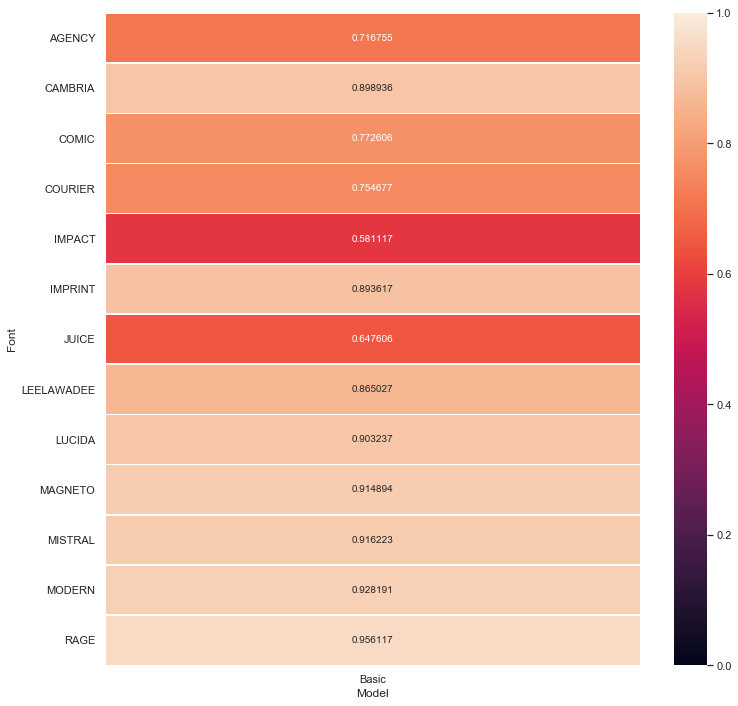

In [161]:
xm2 = pd.DataFrame.from_dict(chain_results, orient='index')
xm2.to_csv('xm2.csv')
xm2 = pd.read_csv('xm2.csv')
matrix2 = xm2.pivot("Font", "Model", "Accuracy")
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(matrix2, annot=True, fmt="f", linewidths=.5, ax=ax, vmin=0, vmax=1)

Made some improvements, and had some fun along the way.